In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

## 🧾 Tiền xử lý dữ liệu người dùng

> *Quá trình tiền xử lý được thực hiện trên bộ dữ liệu `cresci-2015`, tập trung vào các thông tin liên quan đến tài khoản người dùng. Dữ liệu được lấy từ hai nguồn khác nhau, gồm tài khoản thật và tài khoản giả mạo (bot), sau đó được gộp lại thành một tập duy nhất. Các giá trị thiếu được xử lý phù hợp với kiểu dữ liệu và dữ liệu dạng chuỗi được mã hóa để phục vụ cho việc huấn luyện mô hình. Việc chọn lọc các cột thông tin quan trọng giúp giảm nhiễu và tăng hiệu quả phân tích. Tập dữ liệu sau xử lý sẽ được sử dụng để phân tích và xây dựng mô hình phát hiện tài khoản giả mạo.*

In [ ]:
# Chọn các cột hữu ích từ dữ liệu người dùng
useful_cols = ['id', 'statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count', 'lang', 'time_zone', 'location', 'dataset']

# Đọc dữ liệu người dùng từ các tập tin CSV, kết hợp chúng và chỉ giữ lại các cột hữu ích
users = pd.concat([
    pd.read_csv("../cresci-2015/E13/users.csv"),
    pd.read_csv("../cresci-2015/INT/users.csv")],
    ignore_index=True)[useful_cols]

# Lấp đầy các giá trị thiếu và mã hóa dữ liệu người dùng
for col in users.columns:
    if users[col].dtype == 'object':
        users[col] = LabelEncoder().fit_transform(users[col].fillna('NaN'))
    else:
        users[col] = users[col].fillna(0)
display(users)

,id,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,time_zone,location,dataset
0,3610511,20370,5470,2385,145,52,5,29,1006,0
1,5656162,3131,506,381,9,40,1,29,1022,0
2,5682702,4024,264,87,323,16,1,29,551,0
3,6067292,40586,640,622,1118,32,1,29,793,0
4,6015122,2016,62,64,13,0,5,29,1459,0
...,...,...,...,...,...,...,...,...,...,...
2813,1391497074,1,0,17,0,0,1,23,776,1
2814,1391544607,0,1,17,0,0,1,23,793,1
2815,1391622127,2,0,15,0,0,1,23,1024,1
2816,1391832212,2,0,16,0,0,1,23,793,1


## 🔗 Xử lý dữ liệu bạn bè và xây dựng cạnh đồ thị

>*Bước này nhằm xây dựng danh sách các kết nối giữa người dùng để tạo đồ thị mạng xã hội phục vụ cho các mô hình `GNN`. Dữ liệu bạn bè được tổng hợp từ hai tập tin riêng biệt, sau đó hợp nhất thành một bảng duy nhất chứa các mối quan hệ. Mỗi người dùng được ánh xạ sang một chỉ mục cụ thể để dễ dàng tham chiếu trong quá trình tạo cạnh. Từ đó, danh sách các cạnh được xây dựng bằng cách ánh xạ các cặp người dùng, đồng thời loại bỏ các kết nối không hợp lệ như trùng lặp hoặc tự kết nối. Kết quả thu được là một bảng danh sách cạnh hoàn chỉnh, đóng vai trò là cấu trúc đồ thị đầu vào cho mô hình học sâu trên đồ thị.*

In [ ]:
# Tải dữ liệu bạn bè từ các tập tin CSV và kết hợp chúng
friends = pd.concat([
    pd.read_csv("../cresci-2015/E13/friends.csv"), 
    pd.read_csv("../cresci-2015/INT/friends.csv")], 
    ignore_index=True)
display(friends)

# Tạo chỉ mục cho người dùng để ánh xạ ID người dùng sang chỉ mục
users_index = {id: index for index, id in enumerate(users.id)}

# Tạo DataFrame cho các cạnh (edge) từ dữ liệu bạn bè
edges = pd.concat([
    pd.DataFrame({
        'source_index': friends['source_id'].map(users_index),
        'target_index': friends['target_id'].map(users_index)
    }),
    pd.DataFrame({
        'source_index': friends['target_id'].map(users_index),
        'target_index': friends['source_id'].map(users_index)
    })
]).dropna().drop_duplicates().query("source_index != target_index").reset_index(drop=True).astype({'source_index': 'long', 'target_index': 'long'})
display(edges)

,source_id,target_id
0,3610511,12
1,3610511,13
2,3610511,380
3,3610511,418
4,3610511,586
...,...,...
1184705,1391998039,617407144
1184706,1391998039,980980376
1184707,1391998039,1014680358
1184708,1391998039,1359182538


,source_index,target_index
0,0,8
1,0,25
2,0,30
3,0,45
4,0,239
...,...,...
4555,1688,2586
4556,2489,2599
4557,2082,2624
4558,1566,2660


## 🧠 Chuyển đổi dữ liệu thành graph tensor

>*Dữ liệu người dùng và các kết nối bạn bè được chuyển đổi thành một cấu trúc đồ thị phục vụ cho huấn luyện mô hình `GNN`. Đặc trưng người dùng được trích xuất từ bảng `users`, sau đó chuyển thành tensor `x`. Danh sách cạnh được biểu diễn dưới dạng tensor `edge_index` theo định dạng `[2, num_edges]`, có thêm `self-loop` để tăng tính ổn định trong quá trình huấn luyện. Nhãn phân loại được lấy từ cột `dataset`, thể hiện tài khoản thật hoặc giả. Cuối cùng, tất cả thành phần được đóng gói vào đối tượng `Data` của thư viện `PyTorch Geometric`, sẵn sàng cho các bước huấn luyện mô hình học sâu trên đồ thị.*

In [4]:
# Chuyển đổi dữ liệu người dùng thành tensor
x = users.drop(['id','dataset'], axis=1).values
x = torch.tensor(x, dtype=torch.float)

# Chuyển đổi dữ liệu cạnh thành tensor và thêm thêm các cạnh tự nối (self-loops)
edge_index = torch.tensor(edges[['source_index', 'target_index']].values, dtype=torch.long).t().contiguous()
edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

# Chuyển đổi nhãn người dùng thành tensor
y = torch.tensor(users.dataset, dtype=torch.long)

# Tạo đối tượng graph từ dữ liệu người dùng, các cạnh và nhãn
graph = Data(x=x, edge_index=edge_index, y=y)
display(graph)

Data(x=[2818, 8], edge_index=[2, 7378], y=[2818])

## 🧪 Chia dữ liệu và tạo mask cho huấn luyện, xác thực và kiểm tra

>*Dữ liệu đồ thị được chia thành ba tập: `huấn luyện, xác thực và kiểm tra` theo tỷ lệ `70/15/15`. Việc chia giữ nguyên phân bố nhãn giữa các tập để đảm bảo tính công bằng trong đánh giá. Các tập được biểu diễn bằng các `mask boolean` gồm `train_mask`, `val_mask` và `test_mask`. Những `mask` này được gán trực tiếp vào đối tượng `graph`. Việc phân chia rõ ràng giúp mô hình được huấn luyện hiệu quả và đánh giá chính xác hơn.*

In [5]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
num_nodes = graph.num_nodes
labels = users.dataset.to_numpy()
train, temp = train_test_split(
    range(num_nodes),
    test_size=0.3, 
    random_state=42,
    stratify=labels
)
val, test = train_test_split(
    temp, 
    test_size=0.5, 
    random_state=42, 
    stratify=labels[temp]
)

# Tạo mask cho tập huấn luyện và tập kiểm tra
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Gán giá trị True cho các chỉ mục trong tập huấn luyện và tập kiểm tra
train_mask[train] = True
val_mask[val] = True
test_mask[test] = True

# Gán các mask vào đối tượng graph
graph.train_mask = train_mask
graph.val_mask = val_mask
graph.test_mask = test_mask
print(f"Train nodes: {graph.train_mask.sum()}, Val nodes: {graph.val_mask.sum()}, Test nodes: {graph.test_mask.sum()}")

Train nodes: 1972, Val nodes: 423, Test nodes: 423


## 🧱 Khởi tạo mô hình GraphSAGE

>*`GraphSAGE (Graph Sample and AggregatE)` được xây dựng bằng thư viện `PyTorch Geometric` với kiến trúc gồm hai lớp tổng hợp hàng xóm (`SAGEConv`). Dữ liệu đầu vào được truyền qua lớp `SAGEConv` đầu tiên, sau đó áp dụng hàm kích hoạt `ReLU` và `dropout`, trước khi chuyển tiếp đến lớp `SAGEConv` thứ hai để đưa ra xác suất phân loại. Quá trình lan truyền thông tin trên đồ thị của `GraphSAGE` được thực hiện thông qua phép tổng hợp (`aggregation`) và ghép nối đặc trưng (`concatenation`) như sau:*
>$$
>\mathbf{h}_v^{(l+1)} = \sigma\left(W^{(l+1)} \cdot \mathrm{CONCAT}\left(\mathbf{h}_v^{(l)},\mathbf{h}_{\mathcal{N}(v)}^{(l+1)}\right)\right)
>$$
>
> *Trong đó:*
>- *$\mathbf{h}_v^{(l)}$: vector đặc trưng của đỉnh $v$ tại lớp $l$*
>- *$\mathcal{N}(v)$: tập các node hàng xóm của $v$*
>- *$\mathbf{h}_{\mathcal{N}(v)}^{(l+1)}$: kết quả tổng hợp (aggregation) các vector đặc trưng của các hàng xóm $u \in \mathcal{N}(v)$ tại lớp $l$, thường tính bởi một hàm như *mean*, *sum* hoặc *max*:*
>$$
>\mathbf{h}_{\mathcal{N}(v)}^{(l+1)} = \mathrm{AGGREGATE}^{(l+1)}\left(\left\{\mathbf{h}_u^{(l)} \mid u \in \mathcal{N}(v)\right\}\right)
>$$
>- *$\mathrm{CONCAT}$: phép ghép nối đặc trưng của node với đặc trưng hàng xóm đã tổng hợp*
>- *$W^{(l+1)}$: ma trận trọng số được học tại lớp $l+1$*
>- *$\sigma$: hàm kích hoạt phi tuyến, thường là ReLU*
>
>*Mô hình được khởi tạo với số đặc trưng đầu vào bằng `graph.num_node_features`, số chiều ẩn là `64`, và đầu ra là `số lớp phân loại dựa trên nhãn người dùng`. Sau khi khởi tạo, mô hình `GraphSAGE` đã sẵn sàng để huấn luyện nhằm phân loại tài khoản thật và giả trong đồ thị người dùng.*

In [6]:
# Định nghĩa mô hình GraphSAGE
class GraphSAGE(torch.nn.Module):
    # Phương thức khởi tạo kiến trúc mô hình GraphSAGE
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, num_classes)
        
    # Phương thức forward để thực hiện quá trình lan truyền qua các lớp SAGEConv
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Khởi tạo mô hình GraphSAGE cụ thể
model = GraphSAGE(graph.num_node_features, 64, len(np.unique(users.dataset)))
display(model)

GraphSAGE(
  (conv1): SAGEConv(8, 64, aggr=mean)
  (conv2): SAGEConv(64, 2, aggr=mean)
)

## 🏋️‍♂️ Huấn luyện và đánh giá mô hình

>*Quá trình huấn luyện mô hình bắt đầu bằng việc khởi tạo bộ tối ưu hóa `Adam` với tốc độ học là `0.01` và hệ số `regularization 5e-4` nhằm hạn chế `overfitting`. Hàm `train()` thực hiện forward pass trên tập train, tính toán hàm mất mát `cross-entropy` và cập nhật trọng số thông qua `lan truyền ngược`. Hàm mất mát được định nghĩa như sau:*
>
>$$
>\mathcal{L}_{\text{train}} = - \sum_{i \in \text{Train}} y_i \cdot \log(\hat{y}_i)
>$$
>
>*Trong khi đó, hàm `test()` chuyển mô hình sang chế độ đánh giá (`eval()`), dự đoán nhãn bằng `argmax`, rồi tính độ chính xác trên cả tập huấn luyện và kiểm tra. Công thức độ chính xác là:*
>
>$$
>\text{Accuracy} = \frac{\text{Số lượng dự đoán đúng}}{\text{Tổng số mẫu trong tập}}
>$$
>
>*Sau nhiều vòng lặp (`epoch`), mô hình dần học được cách phân biệt tài khoản thật và giả dựa trên cấu trúc và đặc trưng của đồ thị người dùng.*

In [7]:
# Khởi tạo bộ tối ưu hóa Adam với mô hình và các tham số học
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
display(optimizer)

# Phương thức huấn luyện mô hình
def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph.x, graph.edge_index)
    loss = F.cross_entropy(out[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Phương thức kiểm tra mô hình
def test():
    model.eval()
    with torch.no_grad():
        out = model(graph.x, graph.edge_index)
        pred = out.argmax(dim=1)
    accs = []
    for mask in [graph.train_mask, graph.val_mask, graph.test_mask]:
        correct = pred[mask] == graph.y[mask]
        acc = int(correct.sum()) / int(mask.sum())
        accs.append(acc)
    return accs

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.0005
)

In [8]:
# Khởi tạo DataFrame để lưu lịch sử huấn luyện
history = pd.DataFrame(columns=['epoch', 'loss', 'train_acc', 'val_acc', 'test_acc'])

# Khởi tạo các giá trị phục vụ lưu kết quả tối ưu nhất
best_val_acc = 0
patience = 50
counter = 0
best_model_state = None

# Huấn luyện mô hình và lưu lịch sử huấn luyện
for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f},  Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    history.loc[len(history)] = {
        'epoch': epoch,
        'loss': loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc
    }
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
    if counter >= patience:
        print(f"GCN Early stopped at epoch {epoch} with Val Acc = {best_val_acc:.4f}")
        break
    if epoch == 100:
        print(f"GCN stopped at epoch {epoch} with Val Acc = {best_val_acc:.4f}")

Epoch: 001, Loss: 591.3204, Train Acc: 0.5254,  Val Acc: 0.5272, Test Acc: 0.5248
Epoch: 002, Loss: 205.0689, Train Acc: 0.5254,  Val Acc: 0.5272, Test Acc: 0.5248
Epoch: 003, Loss: 143.9588, Train Acc: 0.5254,  Val Acc: 0.5272, Test Acc: 0.5272
Epoch: 004, Loss: 71.7321, Train Acc: 0.9219,  Val Acc: 0.9125, Test Acc: 0.9409
Epoch: 005, Loss: 28.2962, Train Acc: 0.9067,  Val Acc: 0.8889, Test Acc: 0.9007
Epoch: 006, Loss: 23.9311, Train Acc: 0.8955,  Val Acc: 0.8771, Test Acc: 0.8913
Epoch: 007, Loss: 29.2132, Train Acc: 0.8879,  Val Acc: 0.8723, Test Acc: 0.8818
Epoch: 008, Loss: 37.7974, Train Acc: 0.8869,  Val Acc: 0.8723, Test Acc: 0.8818
Epoch: 009, Loss: 37.5444, Train Acc: 0.8884,  Val Acc: 0.8747, Test Acc: 0.8818
Epoch: 010, Loss: 40.2758, Train Acc: 0.8950,  Val Acc: 0.8747, Test Acc: 0.8936
Epoch: 011, Loss: 37.9420, Train Acc: 0.9016,  Val Acc: 0.8747, Test Acc: 0.9007
Epoch: 012, Loss: 37.7344, Train Acc: 0.9072,  Val Acc: 0.8842, Test Acc: 0.9031
Epoch: 013, Loss: 29.7898

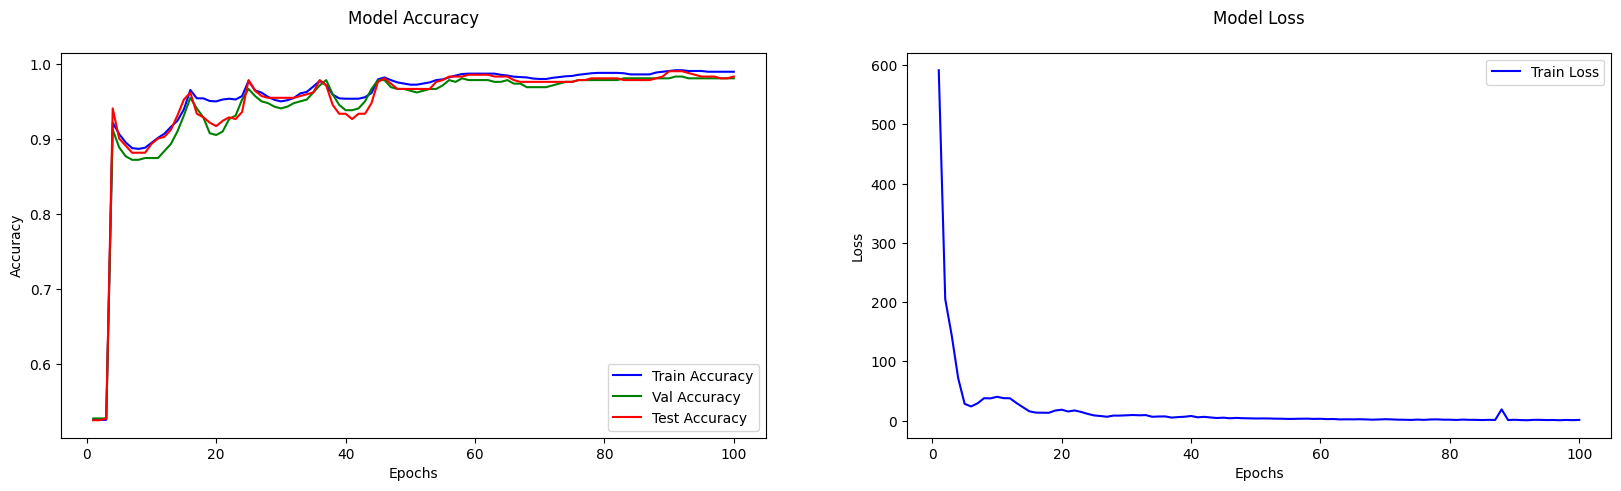

In [9]:
# Gán dữ liệu lịch sử huấn luyện vào các biến để vẽ biểu đồ
loss = history['loss']
train_accuracy = history['train_acc']
val_accuracy = history['val_acc']
test_accuracy = history['test_acc']
epochs = range(1, len(history['loss']) + 1)

# Đặt kích thước biểu đồ
plt.figure(figsize=(20, 5))

# Vẽ biểu đồ chính xác
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b-', label="Train Accuracy")
plt.plot(epochs, val_accuracy, 'g-', label="Val Accuracy")
plt.plot(epochs, test_accuracy, 'r-', label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy\n")
plt.legend()

# Vẽ biểu đồ mất mát
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss\n")
plt.legend()

# Hiển thị biểu đồ
plt.show()

## 📊 Đánh giá hiệu suất mô hình

>*Sau khi huấn luyện, mô hình được đánh giá toàn diện thông qua nhiều chỉ số khác nhau. Đầu tiên là độ chính xác tổng thể (`Accuracy`), được tính bằng tỷ lệ phần trăm số mẫu được phân loại đúng:*
>
>$$
>\text{Accuracy} = \frac{1}{N} \sum_{i=1}^N \mathbf{1}(y_i = \hat{y}_i)
>$$
>
>*Ngoài ra, ma trận nhầm lẫn được sử dụng để phân tích chi tiết số lượng dự đoán đúng/sai giữa các lớp `Real` và `Fake`. Báo cáo phân loại (`Classification Report`) cung cấp các chỉ số quan trọng gồm `Precision`, `Recall` và `F1-score`:*
>
>$$
>\text{Precision} = \frac{TP}{TP + FP}, \quad
>\text{Recall} = \frac{TP}{TP + FN}, \quad
>\text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
>$$
>
>*Cuối cùng, biểu đồ `ROC` và chỉ số `AUC` phản ánh khả năng phân biệt hai lớp của mô hình, trong đó `AUC` được định nghĩa là:*
>
>$$
>\text{AUC} = \int_0^1 \text{TPR}(FPR) \, d(\text{FPR})
>$$
>
>*Tập hợp các chỉ số định lượng này giúp đánh giá toàn diện hiệu suất của mô hình trong việc phân loại tài khoản thật và giả trên đồ thị người dùng.*

              precision    recall  f1-score   support

        Real       1.00      0.98      0.99      1481
        Fake       0.98      1.00      0.99      1337

    accuracy                           0.99      2818
   macro avg       0.99      0.99      0.99      2818
weighted avg       0.99      0.99      0.99      2818



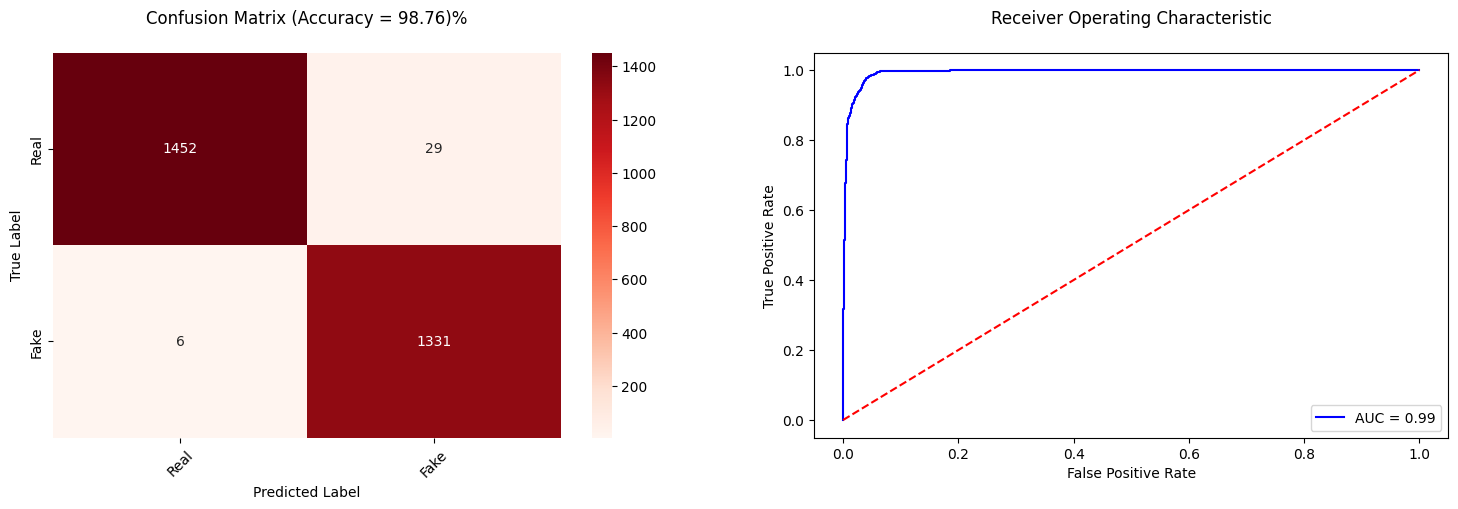

In [10]:
# Kiểm tra trên toàn bộ dữ liệu huấn luyện
model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    out = model(graph.x, graph.edge_index)
    predictions = out.argmax(dim=1).numpy()
    acc = (predictions == graph.y.numpy()).sum() / graph.y.size(0)
    true_labels = graph.y.numpy()
    probs = out[:, 1].numpy()
cm = confusion_matrix(graph.y.numpy(), predictions)
roc_auc = roc_auc_score(true_labels, probs)
fpr, tpr, thresholds = roc_curve(true_labels, probs)

# Hiển thị các chỉ số đánh giá mô hình
print(classification_report(true_labels, predictions, target_names=["Real", "Fake"]))

# Đặt kích thước biểu đồ
plt.figure(figsize=(18, 5))

# Vẽ ma trận nhầm lẫn
plt.subplot(1, 2, 1)
class_names = ['Real', 'Fake']
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Accuracy = {acc*100:.2f})%\n')

# Vẽ biểu đồ ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("Receiver Operating Characteristic\n")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

# Hiển thị biểu đồ
plt.show()